**Описание проекта: телекоммуникации**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

*Описание услуг*

Оператор предоставляет два основных типа услуг:

•	Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.

•	Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

*Также доступны такие услуги:*

•	Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);

•	Выделенная линия технической поддержки (TechSupport);

•	Облачное хранилище файлов для резервного копирования данных (OnlineBackup);

•	Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

In [1]:
#импорты 
!pip install shap
!pip install matplotlib
!pip install --upgrade shap matplotlib seaborn -q
!pip install phik
!pip install --upgrade scikit-learn
!pip install catboost

import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phik

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor

from phik import phik_matrix, resources, report
from phik.report import plot_correlation_matrix

In [2]:
RANDOM_STATE = 100225
TEST_SIZE = 0.25
threshold = 0.5
metrica_threshold = 0.85

# Шаг 1. Загрузка данных
Загрузите данные и выполните их первичный осмотр.

### Загрузка данных из файлов

In [3]:
contract_data = pd.read_csv('/datasets/contract_new.csv')
personal_data = pd.read_csv('/datasets/personal_new.csv')
internet_data = pd.read_csv('/datasets/internet_new.csv')
phone_data = pd.read_csv('/datasets/phone_new.csv')

### Первичный осмотр данных


**contract_data**

In [4]:
contract_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [5]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
contract_data.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [7]:
# Переведем данные столбца TotalCharges в числовой формат

contract_data['TotalCharges'] = pd.to_numeric(contract_data['TotalCharges'], errors='coerce')

In [8]:
contract_data.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2118.621822
std,30.090047,2112.736199
min,18.250000,19.050000
25%,35.500000,439.745000
50%,70.350000,1345.275000
75%,89.850000,3239.317500
max,118.750000,9221.380000


**personal_data**

In [9]:
personal_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
personal_data.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


**internet_data**

In [12]:
internet_data.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [13]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
internet_data.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0689-DSXGL,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


**phone_data**

In [15]:
phone_data.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [16]:
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [17]:
phone_data.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,0689-DSXGL,No
freq,1,3390


#### Анализ данных contract_data
- Изучение структуры данных:
  Проверим на наличие пропусков в столбцах, соответствие типов данных и уникальные значения.

In [18]:
contract_data.isnull().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64

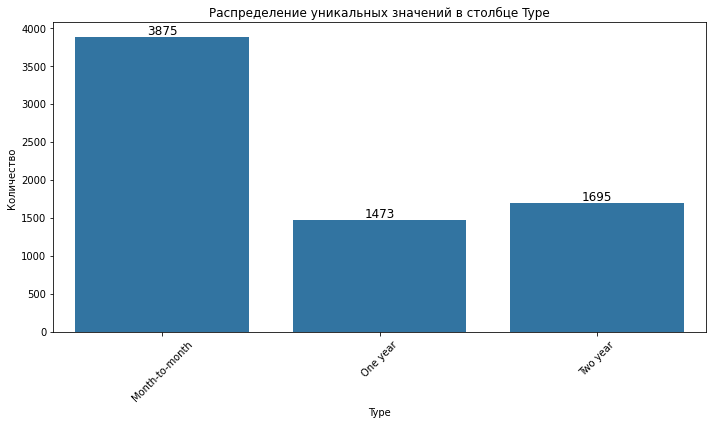

In [19]:
# Получаем уникальные значения из столбца 'Type'
unique_types = contract_data['Type'].unique()

# Построим столбчатую диаграмму для столбца 'Type'
plt.figure(figsize=(10, 6))
sns.countplot(data=contract_data, x='Type')

# Выведем значения уникальных типов на диаграмме
for i, type in enumerate(unique_types):
    count = contract_data[contract_data['Type'] == type].shape[0]
    plt.text(i, count + 0.15, str(count), ha='center', va='bottom', fontsize=12)

# Настройки диаграммы
plt.title('Распределение уникальных значений в столбце Type')
plt.xlabel('Type')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()

# Показать диаграмму
plt.show()

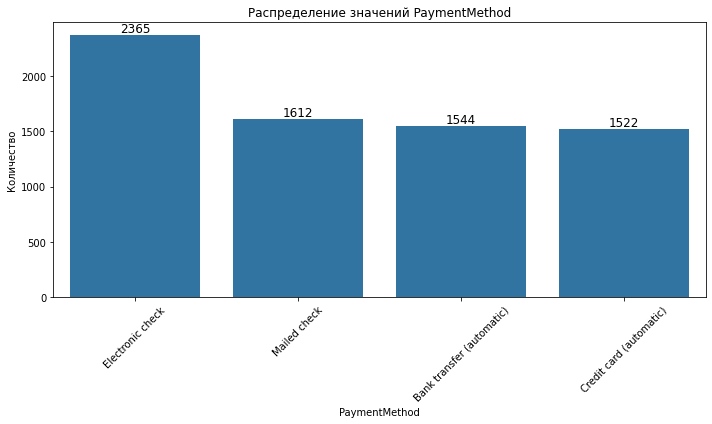

In [20]:
# Диаграмма для PaymentMethod
plt.figure(figsize=(10, 6))
sns.countplot(data=contract_data, x='PaymentMethod', order=contract_data['PaymentMethod'].value_counts().index)

# Добавляем текстовые метки с количеством
for i, method in enumerate(contract_data['PaymentMethod'].value_counts().index):
    count = contract_data[contract_data['PaymentMethod'] == method].shape[0]
    plt.text(i, count + 0.15, str(count), ha='center', va='bottom', fontsize=12)

# Настройки
plt.title('Распределение значений PaymentMethod')
plt.xlabel('PaymentMethod')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()

# Показать диаграмму
plt.show()

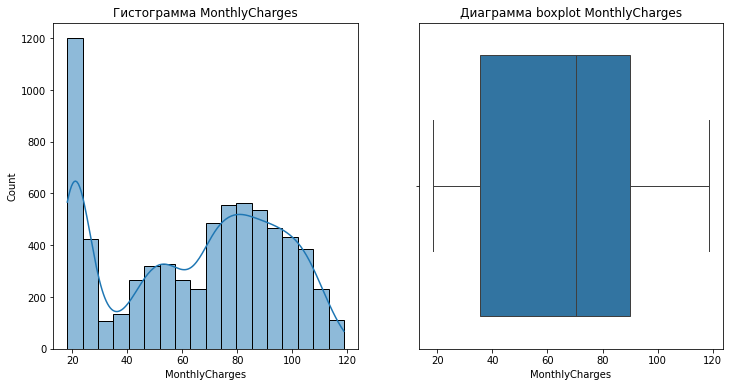

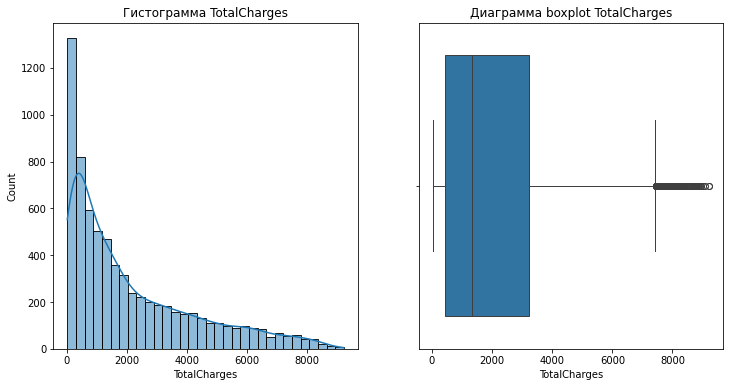

In [21]:
# Визуализация  числовых данных
numerical_features = ['MonthlyCharges', 'TotalCharges']
for feature in numerical_features:
    plt.figure(figsize=(12,6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data=contract_data, x=feature, kde=True)
    plt.title(f'Гистограмма {feature}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=contract_data, x=feature)
    plt.title(f'Диаграмма boxplot {feature}')
    
    plt.show()

#### Анализ данных personal_data
- Изучение структуры:
- Проверка распределения категорий в каждом признаке, например gender, SeniorCitizen, Partner и Dependents.

/tmp/ipykernel_862/68624802.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel')


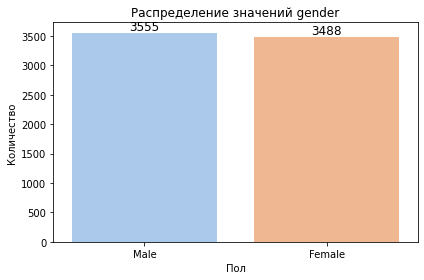

In [22]:
# Подсчет количества значений в столбце gender
gender_counts = personal_data['gender'].value_counts()

# Построение столбчатой диаграммы для столбца gender
plt.figure(figsize=(6, 4))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel')

# Добавление текстовых меток с количеством
for i, count in enumerate(gender_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=12)

# Настройки
plt.title('Распределение значений gender')
plt.xlabel('Пол')
plt.ylabel('Количество')
plt.tight_layout()

# Показать диаграмму
plt.show()


/tmp/ipykernel_862/1387570523.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=senior_counts.index, y=senior_counts.values, palette='viridis')


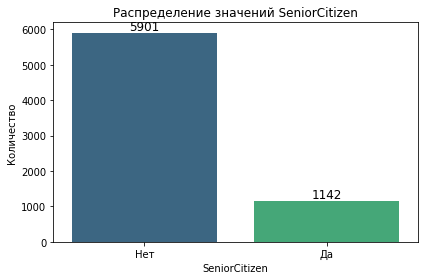

In [23]:
# Подсчет количества значений в столбце SeniorCitizen
senior_counts = personal_data['SeniorCitizen'].value_counts()

# Построение столбчатой диаграммы для столбца SeniorCitizen
plt.figure(figsize=(6, 4))
sns.barplot(x=senior_counts.index, y=senior_counts.values, palette='viridis')

# Добавление текстовых меток с количеством
for i, count in enumerate(senior_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=12)

# Настройки
plt.title('Распределение значений SeniorCitizen')
plt.xlabel('SeniorCitizen')
plt.ylabel('Количество')
plt.xticks(ticks=[0, 1], labels=['Нет', 'Да'])  # если 0 и 1 означают отсутствие и наличие статуса "старший гражданин"
plt.tight_layout()

# Показать диаграмму
plt.show()

/tmp/ipykernel_862/3933522317.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=partner_counts.index, y=partner_counts.values, palette='pastel')


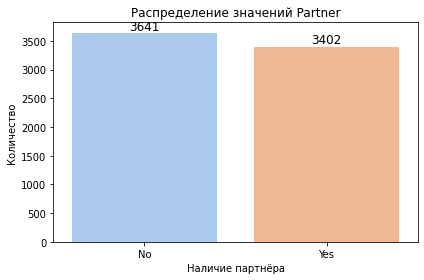

In [24]:
# Подсчет количества значений в столбце Partner
partner_counts = personal_data['Partner'].value_counts()

# Построение столбчатой диаграммы
plt.figure(figsize=(6, 4))
sns.barplot(x=partner_counts.index, y=partner_counts.values, palette='pastel')

# Добавление текстовых меток с количеством
for i, count in enumerate(partner_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=12)

# Настройки
plt.title('Распределение значений Partner')
plt.xlabel('Наличие партнёра')
plt.ylabel('Количество')
plt.tight_layout()

# Показать диаграмму
plt.show()


/tmp/ipykernel_862/3664874580.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dependents_counts.index, y=dependents_counts.values, palette='muted')


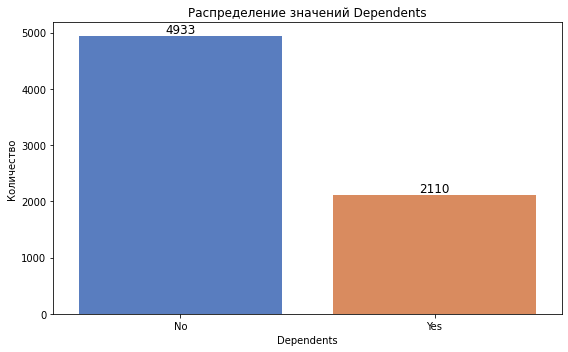

In [25]:
# Подсчет количества значений в столбце Dependents
dependents_counts = personal_data['Dependents'].value_counts()

# Построение столбчатой диаграммы
plt.figure(figsize=(8, 5))
sns.barplot(x=dependents_counts.index, y=dependents_counts.values, palette='muted')

# Добавление текстовых меток с количеством
for i, count in enumerate(dependents_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=12)

# Настройки
plt.title('Распределение значений Dependents')
plt.xlabel('Dependents')
plt.ylabel('Количество')
plt.xticks(rotation=0)  # Угол подписи значений на оси X
plt.tight_layout()

# Показать диаграмму
plt.show()

#### Анализ данных internet_data
- Изучение структуры:
- Проверим, какие услуги подключены (например, OnlineBackup, DeviceProtection), и найдем уникальные значения для типа подключения.

In [26]:
internet_data.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

- Обработка признаков:
  1. Закодируем InternetService через OHE.
  2. Закодируем бинарные услуги, такие как OnlineSecurity, StreamingMovies и прочие, в числовой формат.

#### Анализ данных phone_data
- Изучение структуры:
  Проверьте, сколько пользователей пользуются несколькими телефонными линиями.

/tmp/ipykernel_862/3889378563.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=multiple_lines_counts.index, y=multiple_lines_counts.values, palette='pastel')


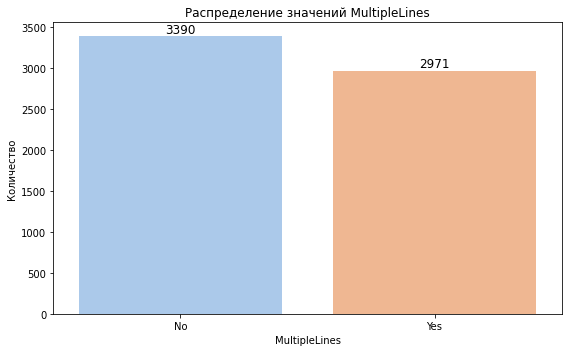

In [27]:
# Подсчет количества значений в столбце MultipleLines
multiple_lines_counts = phone_data['MultipleLines'].value_counts()

# Построение столбчатой диаграммы
plt.figure(figsize=(8, 5))
sns.barplot(x=multiple_lines_counts.index, y=multiple_lines_counts.values, palette='pastel')

# Добавление текстовых меток с количеством
for i, count in enumerate(multiple_lines_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=12)

# Настройки
plt.title('Распределение значений MultipleLines')
plt.xlabel('MultipleLines')
plt.ylabel('Количество')
plt.xticks(rotation=0)  # Угол подписи значений на оси X
plt.tight_layout()

# Показать диаграмму
plt.show()


<div class="alert alert-block alert-success"; style="border-left: 6px solid green">
<b>Успех ✔️</b>
       
Все данные на последней базе нашего курса и предварительно изучены, отлично!)
    
</div>


#### Слияние данных
- Объединение всех датафреймов:
  Используйте столбец customerID для объединения всех таблиц.

In [28]:
# Слияние данных
merged_data = contract_data.merge(personal_data, on='customerID')
merged_data = merged_data.merge(internet_data, on='customerID', how='left')
merged_data = merged_data.merge(phone_data, on='customerID', how='left')

In [29]:
merged_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [30]:
# Проверка итогового датафрейма: Проверьте итоговый датафрейм на пропуски и несоответствия.

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


#### Выводы по данным

- данные "ровные" - аномальных выбросов не обнаружено, модальный ежемесячный платеж - в отрезке 18-23, что является, судя по всему абонентской платой. 
- интересно несовпадение типов графиков между общими расходами и ежемесячными - количество пользователей, тратящих бОльшие суммы на телефонию снижается на графике общих расходов. В то время как график ежемесячных расходов имеет три пика 19, 50 и 80
- датасет internet_new содержит меньшее количество данных, чем остальные таблицы (только данные подключенных к интернету пользователей)

**Портрет пользователей:**

- предпочитают платить ежемесячно и пользуются электронным расчетным счетом 
- примерно одинаковое количество мужчин и женщин 
- преобладают НЕ пенсионеры 
- примерно одинаковое количество пользователей с партнером и одиночек 
- подавляющее количество не имеют детей (70%)
- чуть больше половины пользователей не пользуется подключением к нескольким телефонным линиям


<div class="alert alert-block alert-success"; style="border-left: 6px solid green">
<b>Успех ✔️</b>
       
Объединение сделано корректно
    
</div>


# Шаг 2. Исследовательский анализ и предобработка данных

## Предобработка данных

### Обработка пропусков

In [31]:
# Учтем предположение, что пропущенные значения в internet_new.csv и столбец MultipleLines означают отсутствие использования и заполним их значением "No"

columns_to_fill = [
    'OnlineSecurity',    'OnlineBackup',
    'DeviceProtection',  'TechSupport',
    'StreamingTV',       'StreamingMovies',
    'InternetService',   'MultipleLines'
]

# Замена NaN на "No"
merged_data[columns_to_fill] = merged_data[columns_to_fill].fillna("No")

In [32]:
# Убираем пропуски в столбце TotalCharges 

merged_data = merged_data.dropna(subset=['TotalCharges'])

In [33]:
# Проверяем на отсутствие пропусков

merged_data.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

### Добавление целевого признака

In [34]:
# Добавление целевого признака 
# Преобразование значений столбца EndDate в строки на случай, если они в другом формате
merged_data['EndDate'] = merged_data['EndDate'].astype(str)

# Добавление нового столбца left на основании значений столбца EndDate
merged_data['left'] = merged_data['EndDate'].apply(lambda x: 0 if x.lower() == 'no' else 1)

# Вывод первых строк для проверки
merged_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,left
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


/tmp/ipykernel_862/2888130583.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=left_counts.index, y=left_counts.values, palette='pastel')


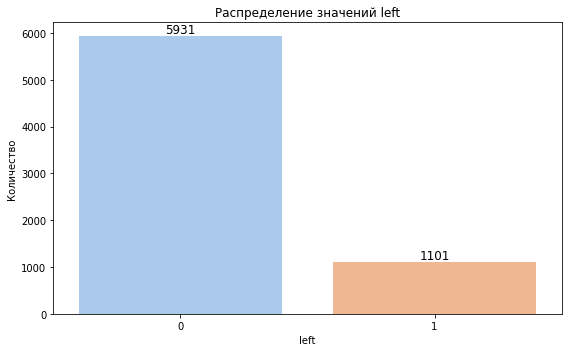

In [35]:
# Подсчет количества значений в столбце целевого признака
left_counts = merged_data['left'].value_counts()

# Построение столбчатой диаграммы
plt.figure(figsize=(8, 5))
sns.barplot(x=left_counts.index, y=left_counts.values, palette='pastel')

# Добавление текстовых меток с количеством
for i, count in enumerate(left_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=12)

# Настройки
plt.title('Распределение значений left')
plt.xlabel('left')
plt.ylabel('Количество')
plt.xticks(rotation=0)  # Угол подписи значений на оси X
plt.tight_layout()

# Показать диаграмму
plt.show()


Количество покинувших компанию гораздо меньше, чем количество оставшихся

### Работа с признаками

In [36]:
# Узнаем максимальную дату в столбце 'EndDate'
# Преобразуем столбец 'EndDate' в формат datetime, заменяя некорректные значения на NaT
contract_data['EndDate'] = pd.to_datetime(contract_data['EndDate'], errors='coerce')

# Найдем максимальную дату, игнорируя NaT
max_end_date = contract_data['EndDate'].max()

print(max_end_date)

2020-01-01 00:00:00


In [37]:
# Создаем 

merged_data.loc[merged_data.EndDate == 'No', ['EndDate']] = '2020-02-01'

# Преобразуйте колонки BeginDate и EndDate в формат datetime
merged_data['BeginDate'] = pd.to_datetime(merged_data['BeginDate'])
merged_data['EndDate'] = pd.to_datetime(merged_data['EndDate'])

# Создайте новый признак duration - количество дней в качестве клиента компании
merged_data['duration'] = (merged_data.EndDate - merged_data.BeginDate).dt.days

# Посмотрите на первые пять строк DataFrame
merged_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,left,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


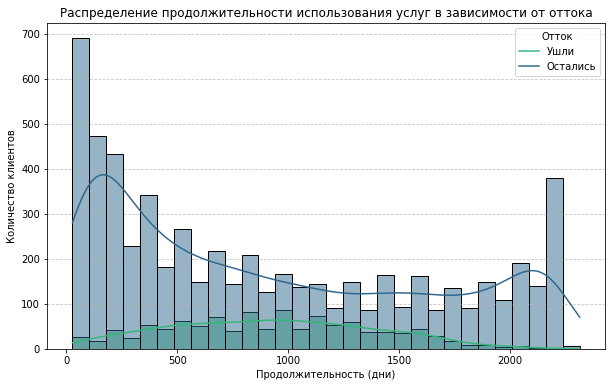

In [38]:
# Построим гистограмму для распределения duration в зависимости от оттока
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_data, x='duration', hue='left', kde=True, bins=30, palette='viridis')
plt.title('Распределение продолжительности использования услуг в зависимости от оттока')
plt.xlabel('Продолжительность (дни)')
plt.ylabel('Количество клиентов')
plt.legend(title='Отток', labels=['Ушли', 'Остались'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [39]:
# Удаляем признаки, которые не будем использовать
merged_data = merged_data.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [40]:
# Анализ корреляции:

# Задаем интервал переменных
interval_cols = ['MonthlyCharges', 'TotalCharges', 'duration']

# Вычисление корреляционной матрицы с помощью Phik
corr_matrix = merged_data.phik_matrix(interval_cols=interval_cols)

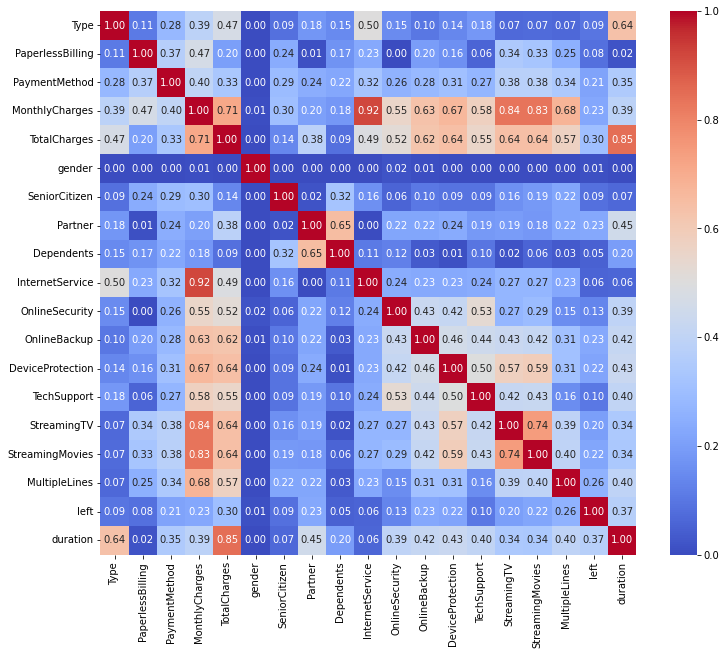

In [41]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

Выявлена очень высокая положительная корреляция между "MonthlyCharges" и "InternetService" высокая положительная корреляция между "MonthlyCharges" и признаками: "StreamingTV" и "StreamingMovies" 

# Удаление нерелевантных признаков
merged_data = merged_data.drop(columns=['InternetService','StreamingTV','StreamingMovies','gender'])

In [42]:
# Предположим, что 'left' - это целевой признак
target = 'left'

# Определите числовые и категориальные признаки
numeric_features = merged_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Убедитесь, что целевой признак удаляется только если он есть в списке numeric_features
if target in numeric_features:
    numeric_features.remove(target)  # Удалить целевой признак из списка

categorical_features = merged_data.select_dtypes(include=['object', 'bool']).columns.tolist()

In [43]:
# Разделение данных на признаки и целевой признак
X = merged_data.drop('left', axis=1)
y = merged_data['left']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [44]:
# Определение полиномиальных признаков на числовых данных
poly_features = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Создание пайплайнов для числовых и категориальных данных
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', poly_features),  # Добавляем полиномиальные признаки
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединение задачи для числовых и категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Создание финального пайплайна
pipe_final = Pipeline([
    ('preprocessor', preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Сетка параметров для GridSearch
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']    
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']    
    }
]

# Обучение через GridSearch
grid_search = GridSearchCV(
    estimator=pipe_final,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    error_score='raise'
)

try:
    grid_search.fit(X_train, y_train)
    
    # Результаты GridSearch
    results = grid_search.cv_results_
    mean_scores = results['mean_test_score']
    
    for mean, params in zip(mean_scores, results['params']):
        print(f'ROC AUC: {mean:.4f} для параметров: {params}')
    
    # Лучшая модель
    best_model_score = grid_search.best_score_
    print('\n**Лучшая модель и её параметры:**\n\n', grid_search.best_estimator_)
    print('**Метрика лучшей модели (ROC AUC) на тренировочной выборке:**', best_model_score)
    
    # Проверка порога качества
    if best_model_score >= metrica_threshold:
        # Метрика на тестовой выборке
        y_test_pred = grid_search.predict_proba(X_test)[:, 1]
        print(f'**Метрика ROC-AUC на тестовой выборке:** {roc_auc_score(y_test, y_test_pred)}')
    else:
        print('*Модель не прошла установленный порог качества.*')
except ValueError as e:
    print(e)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


ROC AUC: 0.6303 для параметров: {'models': DecisionTreeClassifier(random_state=100225), 'models__max_depth': 2, 'models__max_features': 2, 'preprocessor__num__scaler': StandardScaler()}
ROC AUC: 0.6303 для параметров: {'models': DecisionTreeClassifier(random_state=100225), 'models__max_depth': 2, 'models__max_features': 2, 'preprocessor__num__scaler': MinMaxScaler()}
ROC AUC: 0.6303 для параметров: {'models': DecisionTreeClassifier(random_state=100225), 'models__max_depth': 2, 'models__max_features': 2, 'preprocessor__num__scaler': 'passthrough'}
ROC AUC: 0.6237 для параметров: {'models': DecisionTreeClassifier(random_state=100225), 'models__max_depth': 2, 'models__max_features': 3, 'preprocessor__num__scaler': StandardScaler()}
ROC AUC: 0.6237 для параметров: {'models': DecisionTreeClassifier(random_state=100225), 'models__max_depth': 2, 'models__max_features': 3, 'preprocessor__num__scaler': MinMaxScaler()}
ROC AUC: 0.6237 для параметров: {'models': DecisionTreeClassifier(random_stat

In [45]:
# Конвертируем категориальные переменные в строковый тип
X[categorical_features] = X[categorical_features].astype(str)

# Указываем индексы категориальных признаков для CatBoost
cat_features_indices = [X.columns.get_loc(col) for col in categorical_features]

# Определение модели CatBoost
model = CatBoostClassifier(
    random_state=RANDOM_STATE,
    cat_features=cat_features_indices,
    verbose=0
)

# Параметры для поиска
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [6, 8],
    'learning_rate': [0.1, 0.05]
}

# Обучение модели при помощи GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

try:
    # Выполняем обучение
    grid_search.fit(X, y)

    # Результаты
    print("Лучшие параметры:", grid_search.best_params_)
    print("Лучший ROC-AUC на тренировочной выборке:", grid_search.best_score_)

    # Проверка порога метрики
    if grid_search.best_score_ >= metrica_threshold:
        y_pred = grid_search.best_estimator_.predict_proba(X)[:, 1]
        print(f'ROC-AUC на всех данных: {roc_auc_score(y, y_pred):.4f}')
    else:
        print("*Модель не прошла установленный порог качества.*")

except Exception as e:
    print("Ошибка:", e)

Лучшие параметры: {'depth': 6, 'iterations': 300, 'learning_rate': 0.1}
Лучший ROC-AUC на тренировочной выборке: 0.8988412153020406
ROC-AUC на всех данных: 0.9655


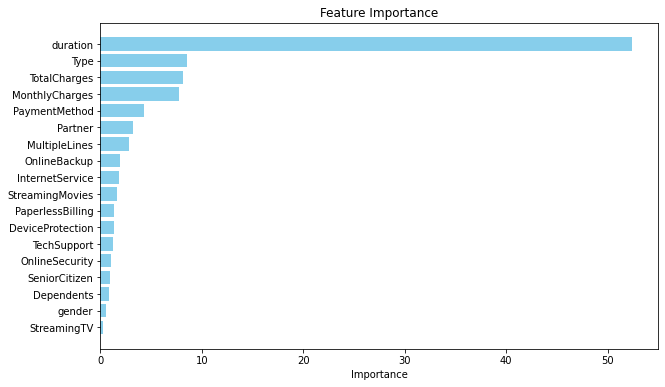

In [46]:
# Построение графика значимости параметров
best_model = grid_search.best_estimator_
feature_importances = best_model.get_feature_importance()
feature_names = X.columns

# Создадим DataFrame для удобства отображения
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by="Importance", ascending=False)

# Построим график
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Инвертируем ось Y для топовых важностей наверху
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

**Топ-5 наиболее значимых признаков:**

• Duration - количество дней в качестве клиента компании 

• TotalCharges — общие расходы абонента

• MonthlyCharges — расходы за месяц

• PaymentMethod — тип платежа


In [47]:
# Вывод списка всех признаков
print("Список всех признаков, на которых обучалась модель:")
for feature in feature_names:
    print(feature)

Список всех признаков, на которых обучалась модель:
Type
PaperlessBilling
PaymentMethod
MonthlyCharges
TotalCharges
gender
SeniorCitizen
Partner
Dependents
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
MultipleLines
duration


In [48]:
# Преобразование вероятностных предсказаний в дискретные классы
y_test_pred_classes = np.where(y_test > threshold, 1, 0)

# Вычисление и вывод матрицы ошибок
cm = confusion_matrix(y_test, y_test_pred_classes)
print('**Матрица ошибок на тестовой выборке:**\n', cm)

# Комментарии к матрице ошибок
tp, fp, fn, tn = cm.ravel()
print(f'\n**Комментарии к матрице ошибок:**\n\n'
      f'TP (True Positives) {tp}: Количество правильных положительных предсказаний.\n'
      f'FP (False Positives) {fp}: Количество неправильных положительных предсказаний.\n'
      f'FN (False Negatives) {fn}: Количество неправильных отрицательных предсказаний.\n'
      f'TN (True Negatives) {tn}: Количество правильных отрицательных предсказаний.')

**Матрица ошибок на тестовой выборке:**
 [[1481    0]
 [   0  277]]

**Комментарии к матрице ошибок:**

TP (True Positives) 1481: Количество правильных положительных предсказаний.
FP (False Positives) 0: Количество неправильных положительных предсказаний.
FN (False Negatives) 0: Количество неправильных отрицательных предсказаний.
TN (True Negatives) 277: Количество правильных отрицательных предсказаний.


Такая матрица ошибок дает представление о качестве работы предсказательной модели:

---

### Метрики матрицы ошибок

1. TP (True Positives) = 1481:  
   Это количество случаев, когда модель правильно классифицировала объект как положительный (например, на самом деле класс был "положительный", и модель его так определила).  
   
2. FP (False Positives) = 0:  
   Это количество случаев, когда модель ошибочно предсказала положительный результат для объектов, которые на самом деле были отрицательными.  

3. FN (False Negatives) = 0:  
   Это количество случаев, когда модель ошибочно не обнаружила положительный класс там, где он реально был.  

4. TN (True Negatives) = 277:  
   Это количество случаев, когда модель правильно предсказала отрицательный результат для объектов, которые на самом деле отрицательные.  

Таким образом: 
    - модель  точно предсказывает правильные значения (как положительные, так и отрицательные)
    - и обнаруживает все положительные случаи
    
Для нашей задачи (прогнозирование оттока клиентов) означает, что 
модель точно предсказывает когда клиент уйдет 


# Вывод: 

•  Проведена первоначальная обработка данных, аномалий не выявлено. При объединении таблиц обнаружены пропуски в internet_new, пропуски заменены на значения "нет услуги" ("No")

•  В самих данных отсутствовал целевой признак, он был выведен из столбца EndDate предположением, что если есть дата окончания договора, то пользователь не является больше клиентом компании

•  выборка была разделена на две подвыборки - тестовую и тренировочную (валидационную)

•  данные числовых столбцов закодированы в несколько категориальных признаков через метод StandardScaler

•  данные категориальных столцов закодированы в несколько категориальных признаков через метод One-hot encoding

•  были удалены столбцы "CustomerId" как не несущий информации и "EndDate" и "BeginDate"  из-за мультиколлинеарности с целевым признаком

•  добавлен признам Duration - количество дней в качестве клиента компании (на момент выгрузки данных)

•  для обучения были выбраны следующие модели: 

    - DecisionTreeClassifier
    - SVC
    - KNeighborsClassifier() 
    - LogisticRegression()
    - CatBoost
    
•  Была использована 5-кратная кросс-валидация (cv=5)

•  Лучший результат показала модель CatBoost с параметрами (Лучшие параметры: {'depth': 6, 'iterations': 300, 'learning_rate': 0.1})
 - Метрика лучшей модели (ROC AUC) на тренировочной выборке: 0.8988412153020406
 - ROC-AUC на всех данных: 0.9655

Значение метрики подходит под условия проекта (больше 0,85)

•  Основные значимые признаки: 

- MonthlyCharges — расходы за месяц;

- TotalCharges — общие расходы абонента

- InternetService

•  Список всех признаков, на которых обучалась лучшая модель:

    • Type
    • PaperlessBilling
    • PaymentMethod
    • MonthlyCharges
    • TotalCharges
    • gender
    • SeniorCitizen
    • Partner
    • Dependents
    • InternetService
    • OnlineSecurity
    • OnlineBackup
    • DeviceProtection
    • TechSupport
    • StreamingTV
    • StreamingMovies
    • MultipleLines
    • duration